In [3]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score, log_loss, precision_score
from pandas import DataFrame, concat
from numpy.random import seed
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from catboost import Pool
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn.preprocessing import PolynomialFeatures
import shap
import datetime
import matplotlib.pyplot as plt
from numpy import max
from pandasql import sqldf
from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd
experiment_model = CatBoostRegressor()
df = pd.read_csv("../data/interim/train.csv")


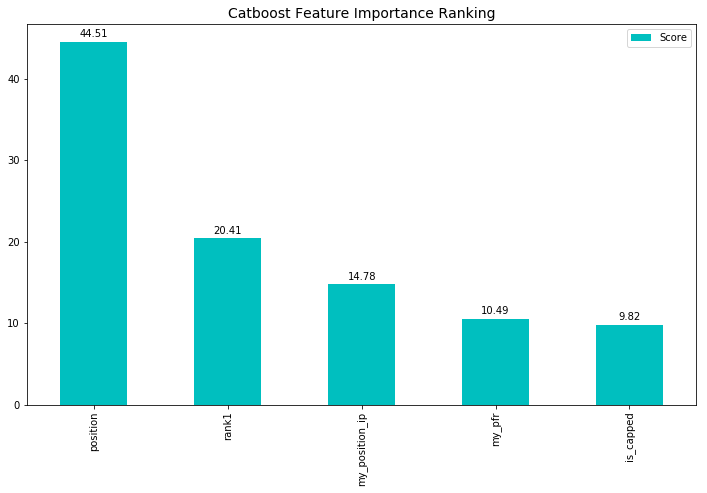

In [87]:
seed(42)
# temp_df = df.copy()
temp_df = df.sample(100000)
# temp_df = df[df["position"] == "BN RFI"]
# X = temp_df.drop(["target", "position"], axis=1)
X = temp_df.drop(["target"], axis=1)
y = temp_df[["target"]]


# X = X[important_columns]
cat_features = [5]

# Get shap dataframes
X = DataFrame(X, columns=X.columns)

# Fit the model on the training set
experiment_model.fit(X, y, cat_features=cat_features, logging_level='Silent')

feature_score = pd.DataFrame(list(zip(X.dtypes.index, experiment_model.get_feature_importance(Pool(X, label=y, cat_features=cat_features)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()


In [88]:
pred_y = experiment_model.predict(X)
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(pred_y, y))
print(score)

2.7636989056468253


In [86]:
# Get important columns
importance_threshold = 7
important_columns = []
for i, x in zip((feature_score['Score'].round(2) > importance_threshold).index, (feature_score['Score'].round(2) > importance_threshold)):
    if x:
        important_columns.append(X.columns[i])
print("important_columns:", important_columns)


important_columns: ['position', 'rank1', 'my_position_ip', 'my_pfr', 'is_capped']


['my_position_ip', 'you_3b', 'you_rfi_and_no_raise', 'is_capped', 'my_pfr', 'rank1', 'is_bb', 'wide_rfi', 'rank2', 'tones', 'rank3', 'top_range', 'is_paired', 'range']


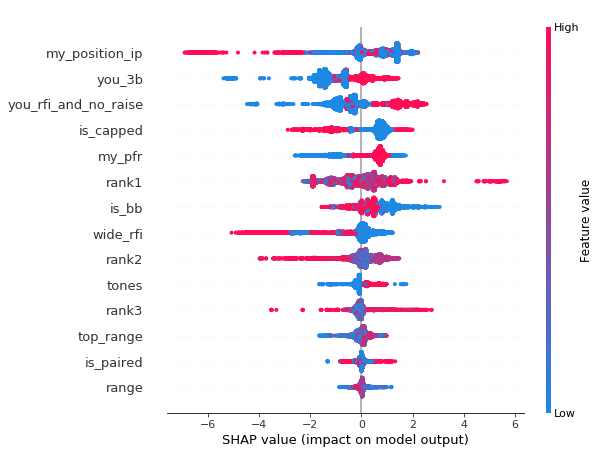

In [49]:
import numpy as np
from pandas import read_csv
from numpy.random import seed
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
warnings.filterwarnings("ignore")

import shap
import pandas as pd
from numpy import cumsum
from xgboost import XGBClassifier

seed(40)

# shap values
shap_values = shap.TreeExplainer(experiment_model).shap_values(X[0:10000])

sorted_feature_importance = pd.DataFrame(shap_values, columns=X.columns).abs().sum().sort_values(ascending=False)
cumulative_sum = cumsum([y for (x,y) in sorted_feature_importance.reset_index().values])
gt_999_importance = cumulative_sum / cumulative_sum[-1] > .999
nth_feature = min([y for (x,y) in zip(gt_999_importance, zip(range(len(gt_999_importance)))) if x])[0]
important_columns = sorted_feature_importance.iloc[0:nth_feature+1].index.values.tolist()
print(important_columns)

plt.clf()
shap.summary_plot(shap_values, X[0:10000])



- Primary
    - **When IP:** Lower
- Secondary
    - **If Capped Range**: Lower
    - **You have a wide range**: Lower    
    - **If RFI and No Raisers**: Higher
    - **High Rank1**: Higher


## Decision Tree with these 5 features

In [184]:
def remove_everything(string):
    return string.replace("\n0 [","").replace("label=\"","").replace('"] ', '').replace('value = ', ''). \
                  replace('10.5', 'T'). \
                  replace('11.5', 'J'). \
                  replace('12.5', 'Q'). \
                  replace('13.5', 'K'). \
                  replace('samples = ', '')


In [235]:
print(dot_data)

digraph Tree {
node [shape=box] ;
0 [label="rank1 <= 11.5\nmse = 1.699\nsamples = 85636\nvalue = 18.091"] ;
1 [label="rank2 <= 8.5\nmse = 0.744\nsamples = 38991\nvalue = 17.242"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="mse = 0.215\nsamples = 30551\nvalue = 17.012"] ;
1 -> 2 ;
3 [label="mse = 1.778\nsamples = 8440\nvalue = 18.072"] ;
1 -> 3 ;
4 [label="top_range <= 0.5\nmse = 1.391\nsamples = 46645\nvalue = 18.8"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="mse = 0.557\nsamples = 4016\nvalue = 17.138"] ;
4 -> 5 ;
6 [label="mse = 1.185\nsamples = 42629\nvalue = 18.957"] ;
4 -> 6 ;
}


In [234]:
dot_data.split(";")[2].split("\\n")[3]

'value = 17.242"] '

In [225]:
remove_everything(dot_data.split(";")[2][5:].split("\\n")[1])

'mse = 0.744'

In [263]:
clf2.tree_.samples[0]

AttributeError: 'sklearn.tree._tree.Tree' object has no attribute 'samples'

In [207]:
temp_df = df.sample(2000000)

score: 3.530869847140163
score: 2.5639283918664733
score: 2.3793788860728315
score: 2.3793788860728315
score: 2.3793788860728315
score: 2.3793788860728315
score: 2.3793788860728315


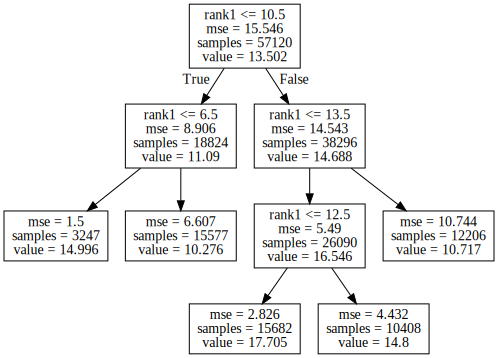

In [293]:
# Get important columns
# importance_threshold = 9
# important_columns = []
# for i, x in zip((feature_score['Score'].round(2) > importance_threshold).index, (feature_score['Score'].round(2) > importance_threshold)):
#     if x:
#         important_columns.append(X.columns[i])
# print("important_columns:", important_columns)


temp_df_new = temp_df[temp_df["position"] == "Villain LJ RFI and You BB Call"].drop(["position"], axis=1) # [["rank1", "my_position_ip", "target"]]

train, test = train_test_split(temp_df_new, test_size=0.40)


train_X = train.drop(["target"], axis=1)
train_y = train[["target"]]
test_X = test.drop(["target"], axis=1)
test_y = test[["target"]]
min_samples_split = int(train_X.shape[0]*0.3)


from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn import tree, linear_model
%matplotlib inline
for i in range(1,7):
    clf2 = tree.DecisionTreeRegressor(max_depth=i, min_samples_split=min_samples_split)
    clf2.fit(train_X, train_y)
    pred_y = clf2.predict(test_X)
    from sklearn.metrics import mean_squared_error
    score = np.sqrt(mean_squared_error(pred_y, test_y))
    print("score:", score)
    # clf2.coef_

CHOICE = 5

clf2 = tree.DecisionTreeRegressor(max_depth=CHOICE, min_samples_split=min_samples_split)
clf2.fit(train_X, train_y)
pred_y = clf2.predict(train_X)
from sklearn.metrics import mean_squared_error
print("score:", score)
dot_data = export_graphviz(clf2, out_file=None, feature_names=train_X.columns)
graph = Source(dot_data)
graph.render("graph")        
graph
# clf2.coef_    


In [290]:
temp_df['position'].value_counts()

CO RFI                               142817
HJ RFI                               142741
LJ RFI                               142727
BN RFI                               142477
Villain LJ RFI and You BB 3Bet       142432
SB RFI                               142426
Villain BN RFI and You SB 3Bet        95961
Villain HJ RFI and You BB 3Bet        95834
Villain SB RFI and You BB 3Bet        95589
Villain HJ RFI and You BB Call        95530
Villain RFI and You 3Bet (Not BB)     95458
CO RFI and You BB Call                95431
Villain BN RFI and You BB 3Bet        95340
Villain LJ RFI and You BB Call        95200
Villain CO RFI and You BB 3Bet        95181
Villain SB RFI and You BB Call        94945
Villain BN RFI and You BB Call        94879
Villain RFI and You Call (Not BB)     23990
You RFI, get 3Bet and you Call        23879
You RFI, get 3Bet and you 4Bet        23836
You Cold 4Bet                         23327
Name: position, dtype: int64

In [291]:
temp_df_new = temp_df[temp_df["position"] == "LJ RFI"].drop(["position"], axis=1) # [["rank1", "my_position_ip", "target"]]
X_new = temp_df_new.drop(["target"], axis=1)
y = temp_df_new[["target"]]

ys = []
for index, row in test_X.iterrows():
    ys.append(18)
#     if row['rank1'] <= 10 or row['is_paired']:
#         ys.append(17)
#     elif row['rank2'] <= 8:
#         ys.append(18)
#     else:
#         ys.append(19)
        
score = np.sqrt(mean_squared_error(ys, test_y))
print("score:", score)


score: 7.561062443089225


In [ ]:
# HJ RFI
ys = []
for index, row in X_new.iterrows():
    if row['rank1'] <= 10 and rank2 <= :
        if row['rank2'] <= 8:
            ys.append(18)
        else:
            ys.append(19)
    else:
        ys.append(17)
score = np.sqrt(mean_squared_error(ys, y))
print("score:", score)


,is_bb,is_capped,is_paired,my_pfr,my_position_ip,range,rank1,rank2,rank3,tones,top_range,wide_rfi,you_3b,you_rfi_and_no_raise
5636273,0,0,0,1,0,6,8,4,2,2,4,0,0,1
1756264,0,0,0,1,0,9,13,6,4,2,7,0,0,1
5210425,0,0,1,1,0,2,5,3,3,2,2,0,0,1
4476523,0,0,0,1,0,6,13,11,7,1,2,0,0,1
2693887,0,0,1,1,0,1,8,8,7,3,0,0,0,1
3045801,0,0,0,1,0,3,8,7,5,1,1,0,0,1
1169809,0,0,0,1,0,7,13,11,6,2,2,0,0,1
311633,0,0,0,1,0,8,11,8,3,2,3,0,0,1
4640292,0,0,0,1,0,5,13,9,8,3,4,0,0,1
989111,0,0,1,1,0,1,9,8,8,2,1,0,0,1


Full rules:
- Call:
    - IP:
        - A-K board: 15   (1%)
        - else: 17    (1%)
    - OOP:
        - A-Q board: 8    (13%)
        - else: 10     (11%)
- PFR:
    - IP:
        - CO/BN: 17     (14%)
        - else: 3        (6%)
    - OOP:
        - CO_BN_SB: 8     (7%)        
        - else: 17      (46%)
           
                                
## Simple rules:

- Called: 10
- Late IP: 17
- Other IP: 3
- Late OOP: 8
- Else: 17




In [115]:
for i, name in zip(range(len(X_new.columns)), X_new.columns):
    print(i, name)




0 is_bb
1 is_capped
2 is_paired
3 my_pfr
4 my_position_ip
5 range
6 rank1
7 rank2
8 rank3
9 tones
10 top_range
11 wide_rfi
12 you_3b
13 you_rfi_and_no_raise


In [ ]:
# from sklearn.tree import _tree

# def tree_to_code(tree, train_X):
#     lookup = {}
#     unique, value = np.unique(clf2.apply(train_X), return_counts=True)
#     for (x, y) in zip(unique, value):
#         lookup[x] = y
    
#     feature_names = train_X.columns
    
#     tree_ = tree.tree_
#     feature_name = [
#         feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
#         for i in tree_.feature
#     ]
#     print("def tree({}):".format(", ".join(feature_names)))

#     def recurse(node, depth):
#         indent = "  " * depth
#         if tree_.feature[node] != _tree.TREE_UNDEFINED:
#             name = feature_name[node]
#             threshold = tree_.threshold[node]
#             print("{}if {} <= {}:".format(indent, name, threshold))
#             recurse(tree_.children_left[node], depth + 1)
#             print("{}else:  # if {} > {}".format(indent, name, threshold))
#             recurse(tree_.children_right[node], depth + 1)
#         else:
#             print("{}return {}".format(indent, tree_.value[node]))

#     recurse(0, 1)
    
# tree_to_code(clf2, train_X)  
    
# def extract_from_tree_size_1(dot_data, total_samples):
#     significant_size = total_samples*0.1
#     rule1 = remove_everything(dot_data.split(";")[1].split("\\n")[0])
#     samples1 = int(remove_everything(dot_data.split(";")[1].split("\\n")[2]))
#     value1 = round(float(remove_everything(dot_data.split(";")[1].split("\\n")[3])))
#     print(rule1, samples1, value1)

#     samples2 = int(remove_everything(dot_data.split(";")[2].split("\\n")[1]))
#     value2 = round(float(remove_everything(dot_data.split(";")[2].split("\\n")[2])))
#     if samples2 >= significant_size:
#         print(samples2, value2)

#     samples3 = int(remove_everything(dot_data.split(";")[4].split("\\n")[1]))
#     value3 = round(float(remove_everything(dot_data.split(";")[4].split("\\n")[2])))
#     if samples3 >= significant_size:
#         print(samples3, value3)
        
#     if samples2 >= significant_size:
        
    
